# Парсинг сайта banki.ru

In [76]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import json
import html
import re
import time
import random
import csv

In [77]:
def parse_reviews(url):
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
    response = requests.get(url, headers=headers)

    soup = BeautifulSoup(response.text, 'html.parser') # парсим ответ как HTML
    script_tag = soup.select_one("body > div.page-container > main.page-container__body > script[type='application/ld+json']") # выбираем элемент скрипта с отзывами
    text = script_tag.string.replace('\r', '') # убираем все символы возврата к началу строки
    text = text.replace('\r', '') # убираем все символы возврата к началу строки
    text = re.sub(r'\n+|\t| ', ' ', text) # заменяем на пробел переносы строки (1 или несколько подряд), табуляцию и неразрывный пробел

    json_data = json.loads(text) # парсим результат как JSON
    reviews = json_data["review"] # сами отзывы находятся в review

    data = []
    for review in reviews:
        text = html.unescape(review["description"]) # раскодируем специальные символы (например, &quot; становится ")
        date = review["datePublished"]

        text = BeautifulSoup(text, 'html.parser').get_text() # сам отзыв у нас тоже в HTML, парсим заново и берём только текст (без разметки)
        text = re.compile("[" # убираем эмодзи (определённые диапазоны Юникода)
               "\U0001F600-\U0001F64F"  # emoticons
               "\U0001F300-\U0001F5FF"  # symbols & pictographs
               "\U0001F680-\U0001F6FF"  # transport & map symbols
               "\U0001F1E0-\U0001F1FF"  # flags (iOS)
               "\U00002500-\U00002BEF"  # chinese char
               "\U00002702-\U000027B0"
               "\U00002702-\U000027B0"
               "\U000024C2-\U0001F251"
               "\U0001f926-\U0001f937"
               "\U00010000-\U0010ffff"
               "\u2640-\u2642"
               "\u2600-\u2B55"
               "\u200d"
               "\u23cf"
               "\u23e9"
               "\u231a"
               "\ufe0f"  # dingbats
               "\u3030"
               "]+", flags=re.UNICODE).sub(r'', text)

        #print(f"Отзыв: {text}\nДата: {date}\n---")
        data.append([text, date])

    return data

data = parse_reviews("https://www.banki.ru/services/responses/bank/tcs/?type=all")
df = pd.DataFrame(data, columns=["Review", "Date",])  # создаем DataFrame из данных
df.to_csv("reviews.csv", index=False, encoding='utf-8')  # записываем DataFrame в CSV-файл

# Предварительная обработка отзывов

In [78]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

In [79]:
# Загрузка стоп-слов и инициализация лемматизатора
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('russian'))
lemmatizer = WordNetLemmatizer()

def preprocess_review(review):
    # Преобразование в нижний регистр
    review = review.lower()
    # Удаление пунктуации
    review = review.translate(str.maketrans('', '', string.punctuation))
    # Лемматизация и удаление стоп-слов
    review = [lemmatizer.lemmatize(word) for word in review.split() if word not in stop_words]
    return ' '.join(review)

data = []
with open('reviews.csv', 'r', encoding='utf-8') as f:
    reader = csv.reader(f)
    next(reader)  # Пропуск заголовка
    for row in reader:
        review, date = row
        review = preprocess_review(review)
        data.append([review, date])

# Запись обработанных данных обратно в CSV
df = pd.DataFrame(data, columns=["Review", "Date",])  # создаем DataFrame из данных
df.to_csv("processed_reviews.csv", index=False, encoding='utf-8')  # записываем DataFrame в CSV-файл


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Преобразование в векторное представление

Краткий обзор каждого векторного представления:

**TF-IDF** хорошо работает, когда важно учесть важность слов в документах и во всем корпусе. Он присваивает больший вес редким словам, которые могут быть более информативными, чем часто встречающиеся слова. Однако TF-IDF не учитывает контекст слов и семантические отношения между ними.

С другой стороны, **Word2Vec** обучается на основе контекста слов, что позволяет ему улавливать семантические отношения между словами, такие как синонимы, антонимы и ассоциации. Однако Word2Vec может быть более сложным в использовании и требовать больше вычислительных ресурсов.


И, в итоге, мы выбрали написать сначала на TF-IDF.




In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

In [81]:
# Создание объекта TfidfVectorizer
vectorizer = TfidfVectorizer()

# Преобразование отзывов в векторное представление с помощью TF-IDF
tfidf_matrix = vectorizer.fit_transform([review for review, date in data])

# Получение списка слов
words = vectorizer.get_feature_names_out()

# Вычисление среднего значения TF-IDF для каждого слова
avg_tfidf = tfidf_matrix.mean(axis=0).A1

# Создание словаря, где ключи - это слова, а значения - средние значения TF-IDF
word_tfidf_dict = dict(zip(words, avg_tfidf))

# Сортировка словаря по значениям в порядке убывания
sorted_word_tfidf_dict = dict(sorted(word_tfidf_dict.items(), key=lambda item: item[1], reverse=True))

In [82]:
tfidf_matrix

<25x959 sparse matrix of type '<class 'numpy.float64'>'
	with 1247 stored elements in Compressed Sparse Row format>

Теперь сделаем визуализацию.

In [83]:
import matplotlib.pyplot as plt

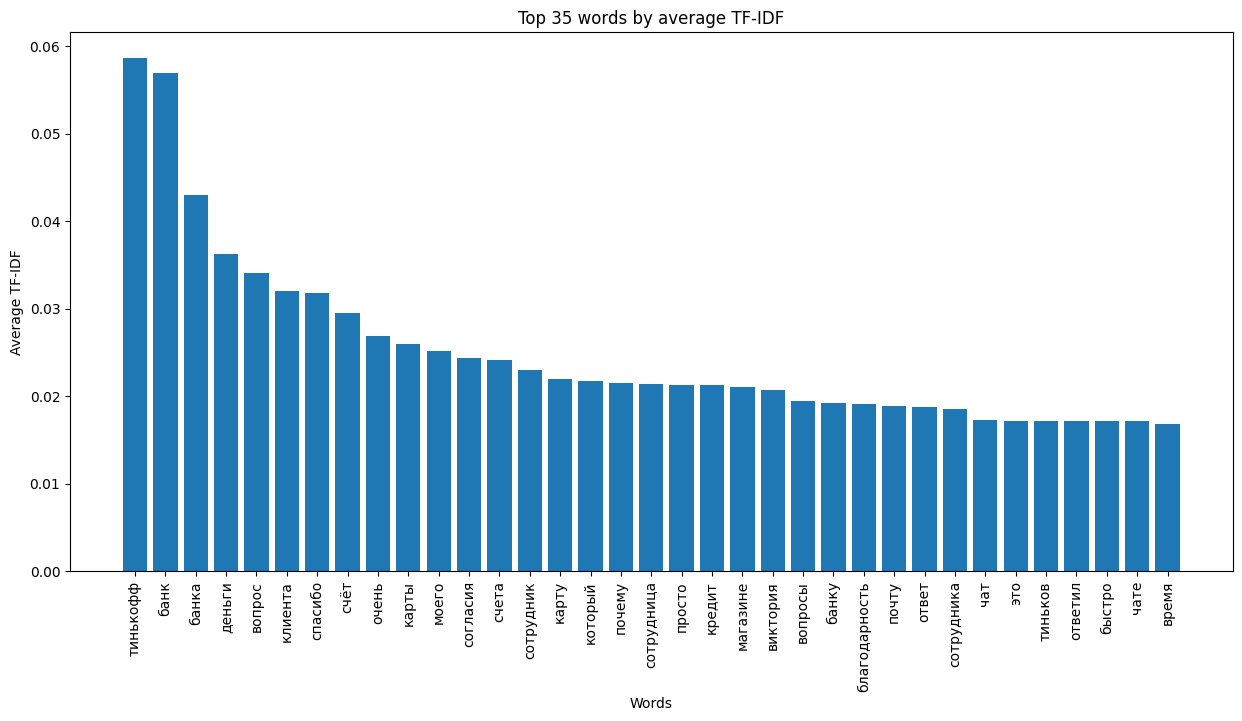

In [84]:
# Визуализация 35 слов с наибольшим значением TF-IDF
plt.figure(figsize=(15, 7))
plt.bar(list(sorted_word_tfidf_dict.keys())[:35], list(sorted_word_tfidf_dict.values())[:35])
plt.title('Top 35 words by average TF-IDF')
plt.xlabel('Words')
plt.ylabel('Average TF-IDF')
plt.xticks(rotation=90)
plt.show()

# Тематическре моделирование

In [85]:
from sklearn.decomposition import LatentDirichletAllocation


In [86]:
# Создание объекта TfidfVectorizer для преобразования отзывов в векторное представление
vectorizer = TfidfVectorizer()

# Преобразование отзывов в векторное представление с помощью TF-IDF
tfidf_matrix = vectorizer.fit_transform([review for review, date in data])

# Выберите количество тем (например, 15)
num_topics = 15

# Создайте объект LDA
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)

# Выполните тематическое моделирование данных
lda.fit(tfidf_matrix)

# Получите темы
topics = lda.components_

In [87]:
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(topics):
    print(f"Тема #{topic_idx + 1}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]))

Тема #1:
поможет сняли подписку деньги вернуть предупредить удивлён старте принадлежит интернете
Тема #2:
подключили клиента согласия денежные ведома услугу средства тинькффф возврат обоснование
Тема #3:
тиньков пользовалась вообщем самый помогут банками многими всем банка просто
Тема #4:
кредитную карту яндексплюса поменять понял привязана привязывал варианты яндексплюс автоматически
Тема #5:
виктора помощи расти обучения персонала проблемы впечатлен меньше вел проверки
Тема #6:
счёт образец предоставили счета технический почту бюджетную организацию рс имя
Тема #7:
чат магазине закона негативный анна анне благодарность банк вопросы сотрудника
Тема #8:
кредит курьер обращение карты течении карту вернули также приходят заявка
Тема #9:
тинькофф виктория сотрудница расчётный банка счёт решил банк очень цены
Тема #10:
причиной легкость злоупотреблять особенностями мог тому скриптами карте никак клиентоориентированности
Тема #11:
убрать звонка ссылке ждать заявку поддержка согласие одобрени

Построем гистограму

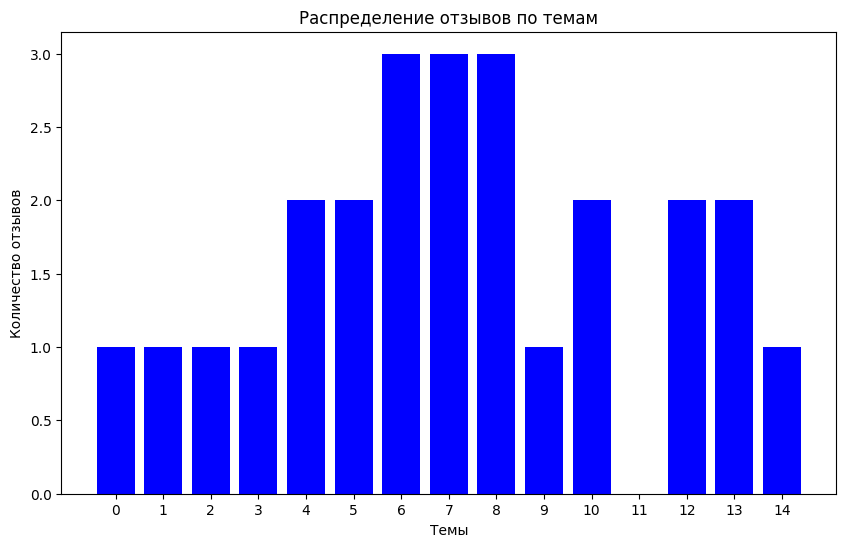

In [88]:
# Получение метки кластеров для всех отзывов
clusters = lda.transform(tfidf_matrix).argmax(axis=1)

# Количество отзывов в каждом кластере
counts = pd.value_counts(clusters)

plt.figure(figsize=(10, 6))
plt.bar(counts.index, counts.values, color='b')
plt.xlabel('Темы')
plt.ylabel('Количество отзывов')
plt.title('Распределение отзывов по темам')
plt.xticks(range(num_topics))
plt.show()

# Частотный анализ

In [89]:
from collections import Counter


In [90]:
# Объединение всех отзывов в одну строку
all_reviews = ' '.join(review for review, date in data)
# Удаление всех неалфавитных символов
all_reviews = re.sub(r'\W+', ' ', all_reviews)
# Разделение текста на слова
words = all_reviews.split()

# Частота каждого слова
word_freq = Counter(words)


In [91]:
print(word_freq.most_common(10))

[('банк', 25), ('тинькофф', 22), ('банка', 15), ('вопрос', 11), ('деньги', 10), ('клиента', 9), ('спасибо', 9), ('счёт', 9), ('очень', 8), ('который', 8)]


Построим гистограмму

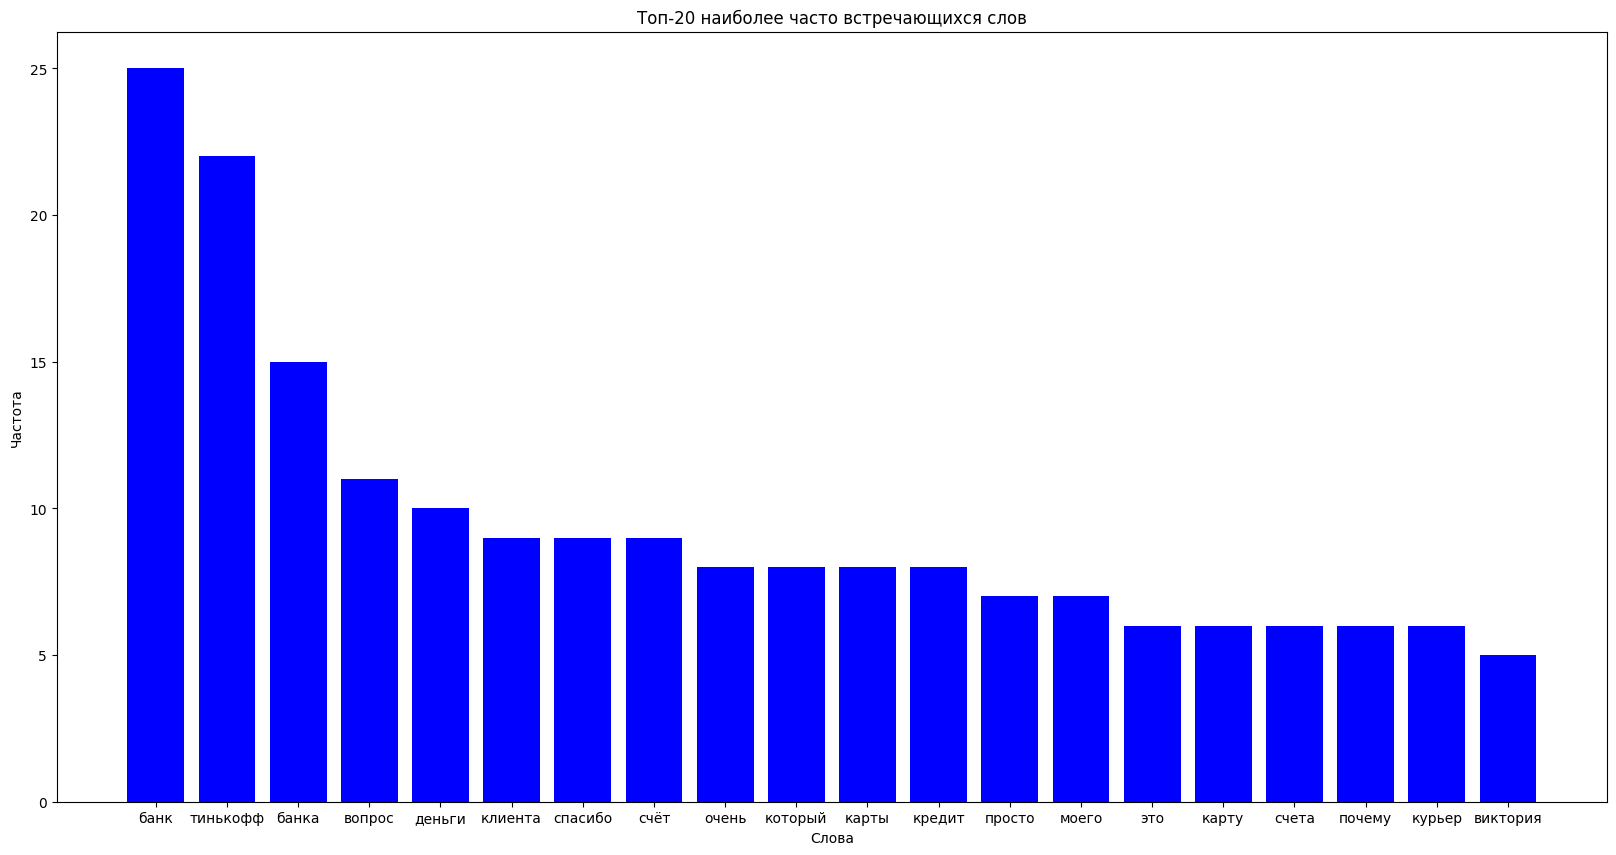

In [92]:
most_common_words = word_freq.most_common(20)


words, frequencies = zip(*most_common_words)  # Разделите пары (слово, частота) на два списка
plt.figure(figsize=(20, 10))
plt.bar(words, frequencies, color='b')
plt.xlabel('Слова')
plt.ylabel('Частота')
plt.title('Топ-20 наиболее часто встречающихся слов')
plt.show()

# Анализ аномалий

Анализ аномалий - это процесс выявления необычных паттернов, которые отклоняются от ожидаемого поведения. В контексте анализа текста, аномалии могут представлять собой отзывы, которые сильно отличаются от остальных.

In [93]:
from sklearn.ensemble import IsolationForest

In [94]:
# Создание объекат IsolationForest
clf = IsolationForest(contamination=0.1)

# Анализ аномалий
preds = clf.fit_predict(tfidf_matrix.toarray())

# Отзывы, которые были классифицированы как -1, считаются аномалиями
anomalies = [data[i] for i, pred in enumerate(preds) if pred == -1]



In [95]:
# Выведите аномальные отзывы
for anomaly in anomalies:
    print(anomaly)

['августе 2023 года открыла карту мир заранее сообищив карта нужна получения бюджетных выплаты получения карты реквизиты передала бюджетную организацию вчера налог увидела открыто рс второго счета приложении банка видно обратилась чат внятного объяснения получила позвонив горячую линию сообщил счёт технический открыт законно моего заявление ссылаясь закон тк получаю бюджетные выплаты открыла платёжки указан рс который изначально который передан бюджетную организацию изначально карта мир деньги поступали проблем нужен технический счёт непонятно никому деньги зачисляются рс который предоставлен получается технический счёт открыт банком целью получить бонусы мол работаем открыли счёт заплатите нам баллы предположить изначальный счёт бюджетный почему банк предложил закрыть вместо передать бюджетную организацию технический счёт просто сотрудники открытии счетов зарабатывают отправлю жалобу цб возможно дадут нормальное разъяснение этому бреду кроме банковский бот неверно произносит мое имя п

Тут визуально не показать(

# Анализ настроения

In [4]:
!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 46.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=65685cb6f946180b88ca551b65e7cb19d7cef8b846add5b35d3752954d701812
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [96]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from google.colab import drive
import pymorphy2
import sys
import re
from scipy.sparse import vstack


In [97]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [98]:
datasets = '/content/drive/Me Drive/Sirius/datasets.csv'

In [105]:
maxInt = sys.maxsize

while True:

    try:
        csv.field_size_limit(maxInt)
        break
    except OverflowError:
        maxInt = int(maxInt/10)

In [108]:
# Открытие файла и чтение данных
with open('datasets.csv', 'r', encoding='ISO-8859-1') as file:
    reader = csv.reader(file)
    data = list(reader)
    df_train = pd.DataFrame(data[1:], columns=data[0])

df_test = pd.read_csv("processed_reviews.csv", encoding='utf-8')

# Лемматизация с помощью pymorphy2
morph = pymorphy2.MorphAnalyzer()
df_train['lemmatized_review'] = df_train['text'].apply(lambda x: ' '.join([morph.parse(word)[0].normal_form for word in re.findall('\w+', str(x))]))

# Векторизация TF-IDF
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(df_train["lemmatized_review"])



In [109]:
# Удаление строк с пропущенными значениями
df_train = df_train.dropna(subset=['sentiment'])
# Удаление последней строки т.к из-за удаление пропущенным значение размерность стала разная
if X_train.shape[0] != df_train['sentiment'].shape[0]:
    X_train = vstack([X_train[i] for i in range(X_train.shape[0]-1)])
# Обучение модели
model = LogisticRegression()
model.fit(X_train, df_train['sentiment'])

# Предсказание настроений
df_test['sentiments'] = model.predict(X_test)



# Сохранение DataFrame в CSV-файл
df_test.to_csv("processed_reviews_with_sentiments.csv", index=False, encoding='utf-8')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
